In [138]:
from ClimSim.climsim_utils import *
import xarray as xr
import os
import importlib
import sys

from lib.physics import get_isa_conditions
importlib.reload(sys.modules['lib.physics'])
from lib.physics import get_isa_conditions

HIGH_RES_SAMPLE_PATH = "data/ClimSim_high-res/train/0002-01"
HIGH_RES_GRID_PATH = "data/ClimSim_high-res/ClimSim_high-res_grid-info.nc"
NORM_PATH = "data/ClimSim/preprocessing/normalizations/"

In [4]:
grid_info = xr.open_dataset(HIGH_RES_GRID_PATH)
samples_list = os.listdir(HIGH_RES_SAMPLE_PATH)

sample_ds = xr.open_dataset(os.path.join(HIGH_RES_SAMPLE_PATH, samples_list[0]))
grid_ds = xr.open_dataset(HIGH_RES_GRID_PATH)


In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.interpolate import griddata

class ClimSimMapper:
    def __init__(self, grid_ds):
        self.grid_ds = grid_ds
        # On récupère les coordonnées de chaque colonne
        self.lats = grid_ds.lat.values
        self.lons = grid_ds.lon.values
        
    def plot_smooth_map(self, data_vector, title="", list_of_POIs=[]):
        grid_lon = np.linspace(0, 360, 360)
        grid_lat = np.linspace(-90, 90, 180)
        lon_2d, lat_2d = np.meshgrid(grid_lon, grid_lat)

        # Interpolation to a regular grid to have proper colormesh
        grid_z = griddata((self.lons, self.lats), data_vector, 
                        (lon_2d, lat_2d), method='nearest')

        plt.figure(figsize=(15, 7))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()
        img = ax.pcolormesh(grid_lon, grid_lat, grid_z, transform=ccrs.PlateCarree(), cmap='RdYlBu_r')

        for pt in list_of_POIs:
            label = pt[3]
            ax.scatter(pt[1], pt[0], transform=ccrs.PlateCarree(), color="b", edgecolors="w", label=label)

        plt.colorbar(img)
        plt.title(title)

    def return_closer_gridpoint_index(self, lat, lon):
        """
        Retourne l'index (flattened) du point de grille le plus proche 
        en utilisant la distance de Haversine.
        """

        lon1, lat1, lon2, lat2 = map(np.radians, [lon, lat, self.lons, self.lats])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        # Formule de Haversine
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        
        c = 2 * np.arcsin(np.sqrt(a))

        return np.argmin(c) #return position in ncol samples

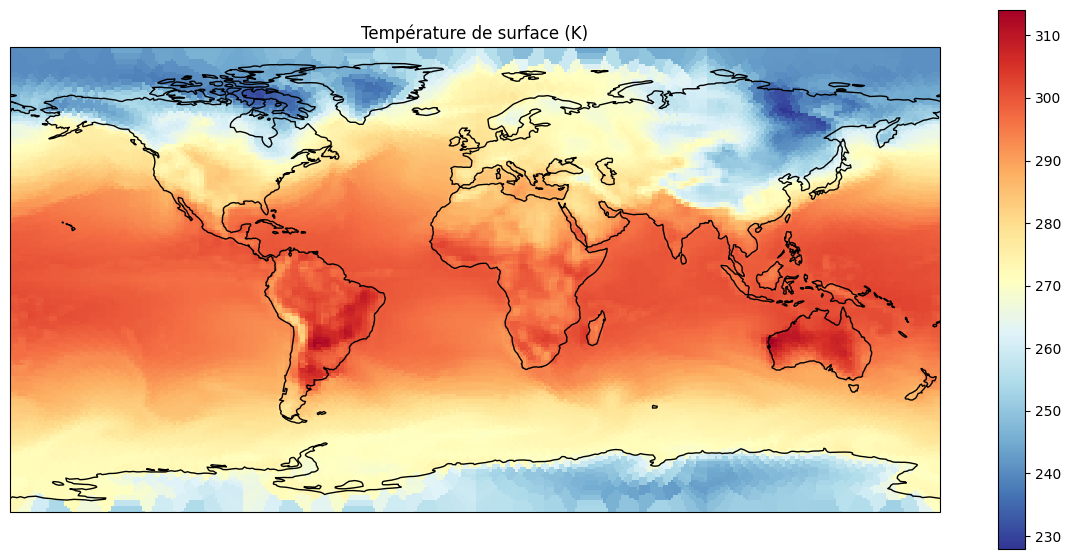

In [17]:
# Initialisation
mapper = ClimSimMapper(grid_info)
sample_to_plot = sample_ds['state_t'].isel(lev=-1).values
mapper.plot_smooth_map(sample_to_plot, title="Température de surface (K)")

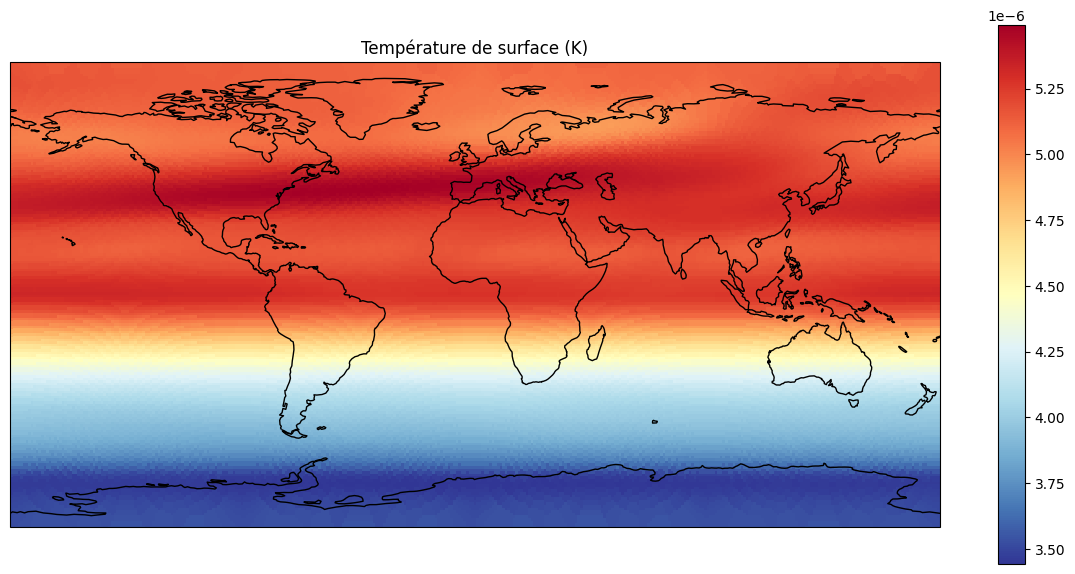

In [11]:
sample_to_plot = sample_ds['pbuf_ozone'].isel(lev=5).values
mapper.plot_smooth_map(sample_to_plot, title="Température de surface (K)")

Altitude: 0.0 m, Couche ISA: 0
Altitude: 80.08008008008008 m, Couche ISA: 0
Altitude: 160.16016016016016 m, Couche ISA: 0
Altitude: 240.24024024024024 m, Couche ISA: 0
Altitude: 320.3203203203203 m, Couche ISA: 0
Altitude: 400.4004004004004 m, Couche ISA: 0
Altitude: 480.4804804804805 m, Couche ISA: 0
Altitude: 560.5605605605606 m, Couche ISA: 0
Altitude: 640.6406406406406 m, Couche ISA: 0
Altitude: 720.7207207207207 m, Couche ISA: 0
Altitude: 800.8008008008007 m, Couche ISA: 0
Altitude: 880.8808808808809 m, Couche ISA: 0
Altitude: 960.960960960961 m, Couche ISA: 0
Altitude: 1041.0410410410411 m, Couche ISA: 0
Altitude: 1121.1211211211212 m, Couche ISA: 0
Altitude: 1201.2012012012012 m, Couche ISA: 0
Altitude: 1281.2812812812813 m, Couche ISA: 0
Altitude: 1361.3613613613613 m, Couche ISA: 0
Altitude: 1441.4414414414414 m, Couche ISA: 0
Altitude: 1521.5215215215214 m, Couche ISA: 0
Altitude: 1601.6016016016015 m, Couche ISA: 0
Altitude: 1681.6816816816818 m, Couche ISA: 0
Altitude: 1761

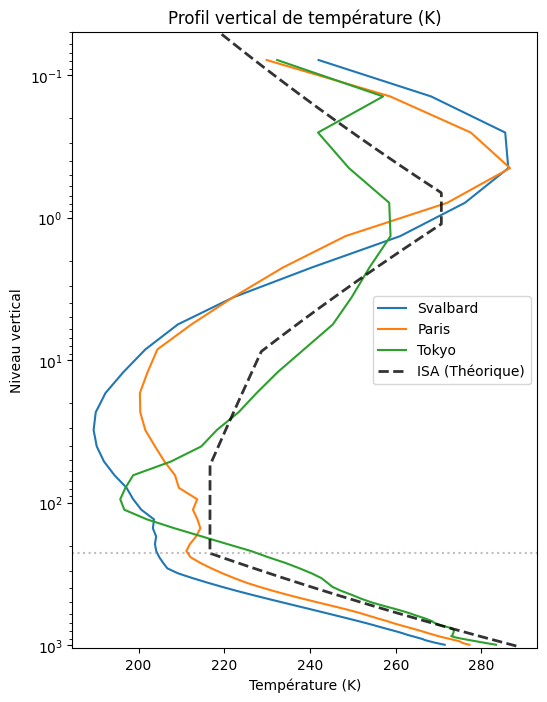

In [140]:
SVALBARD_COORDS = (78.2232, 15.6469, "Svalbard")  # (lat, lon)
PARIS_COORDS = (48.8566, 2.3522, "Paris")      # (lat, lon)
TOKYO_COORDS = (35.6762, 139.6503, "Tokyo")   # (lat, lon)

FEATURE = 'state_t'  # Température

list_of_POIs = [SVALBARD_COORDS, PARIS_COORDS, TOKYO_COORDS]
fts = []
for pt in list_of_POIs:
    index = mapper.return_closer_gridpoint_index(pt[0], pt[1])
    fts.append(sample_ds[FEATURE].isel(ncol=index).values)

altitude_levels = grid_ds['lev'].values



h_range = np.linspace(0, 80000, num=1000) # Altitudes de 0 à 80 km
T_isa, P_isa_pa, _ = get_isa_conditions(h_range)
P_isa_hpa = P_isa_pa / 100.0  # Conversion en hPa pour matcher tes 'lev'

plt.figure(figsize=(6, 8))
for plot_idx, ft in enumerate(fts):
    plt.plot(ft, altitude_levels, label=list_of_POIs[plot_idx][2])
plt.plot(T_isa, P_isa_hpa, label="ISA (Théorique)", linestyle='--', color='k', linewidth=2, alpha=0.8)

plt.yscale('log')          # Échelle logarithmique pour la pression
plt.gca().invert_yaxis()   # Inverser pour avoir 1000 hPa en bas
plt.ylim(1050, 0.05)       # On règle les limites (du sol au sommet)

# Ajout de lignes de repère pour les couches
plt.axhline(226, color='gray', linestyle=':', alpha=0.5) # Limite approx Tropopause (~200hPa)

plt.title("Profil vertical de température (K)")
plt.xlabel("Température (K)")
plt.ylabel("Niveau vertical")
plt.yscale('log')
plt.legend()